# Multiple imputation of missing data

In [ ]:
pre, code {
  max-height: 500px;
  overflow-y: auto;
  white-space: pre !important; 
  overflow-x: auto
}


In [ ]:
library(conflicted)
conflict_prefer("filter", "dplyr")


[conflicted] Will prefer dplyr::filter over any other package.

[conflicted] Will prefer dplyr::select over any other package.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     

* miceadds 3.18-36 (2025-09-12 09:54:54)

Loading required package: colorspace
Loading required package: grid
VIM is ready to use.

Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

### Setup and merge

Read in data

In [ ]:
# b <- read_csv(here::here(path_ready, "base_tst2.csv"), show_col_types = FALSE)
b <- readRDS(here::here(path_ready, "base_tst2.rds"))

diary <- read_csv(here::here(path_ready, "diary_tst2.csv"), show_col_types = FALSE)
# diary <- readRDS(here::here(path_ready, "diary_tst2.rds"))


#### Confirm diary is in long format

In [ ]:
diary %>%
  count(nid) %>%
  summarise(median=median(n), max=max(n), prop_with_repeats=mean(n>1))


# A tibble: 1 × 3
  median   max prop_with_repeats
   <dbl> <int>             <dbl>
1      2    19             0.605

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.

# A tibble: 15 × 2
       n    nn
   <int> <int>
 1     1    60
 2     2    22
 3     3    20
 4     4    14
 5     5    10
 6     6     6
 7     7     5
 8     8     3
 9     9     4
10    10     3
11    11     1
12    12     1
13    13     1
14    15     1
15    19     1

The diary are structured in long format, with one row per event and multiple events nested within participants. A majority of participants (60.5%) contributed more than one event, with a median of two events per participant and up to 19 events for some individuals.

#### Match types and confirm tidy events

In [ ]:
b <-  b %>%
  mutate(
    nid = as.factor(nid))

b <- b %>% 
    rename(base_id = response_id,
           base_prog = progress,
           base_fin = finished,
           base_dur = duration_in_seconds)

diary <- diary %>%
  mutate(
    nid = as.factor(nid),
    date = as.Date(date),
    eid = response_id   # unique event key
  ) %>%
  arrange(nid, date) %>%
  group_by(nid) %>%
  mutate(event_num = row_number()) %>%
  ungroup()

diary <- diary %>% 
  select(-c(response_id))


#### Merge baseline and diary

In [ ]:
d <- diary %>%
  left_join(b %>% distinct(nid, .keep_all = TRUE), by = "nid")


In [ ]:
d <- d %>% 
  select(-c(osb3:traum4, med1_p:med4_p, cub3:cub6, au_t:au_drg))

df <- d %>%
  select(nid, eid, day, bpa, fm_r, intox, p_tox, drink, verb, enon, inon, s_act, prec, 
         aud1, aud2, aud3, aud4, aud5, aud6, aud7, aud8, aud9, aud10, bidr, irma, asco,
         pa1, pa2, pa3, pa4, pa5, pa6, ppat, gend_di, asc1, asc2, asc3, asc4,
         coer1, coer2, coer3, coer4, coer5, coer6) %>% glimpse()


In [ ]:
df <- d %>%
  select(nid, eid, day, bpa, fm_r, intox, p_tox, drink, verb, enon, inon,
         s_act, prec, gend_di, aud1, aud2, aud3, aud4, aud5, aud6, aud7, aud8, aud9, 
         aud10, asco, irma, ppat, bidr) %>% glimpse()


Rows: 501
Columns: 28
$ nid     <fct> 1116912, 1116912, 1215369, 1215369, 1215369, 1224070, 1233417,…
$ eid     <chr> "R_2SGrhBLHNypDxnk", "R_2PvxEpTRi3WqoZh", "R_1MPW5HzrVXnUzPs",…
$ day     <dbl> 10, 25, 4, 10, 11, 19, 11, 20, 22, 27, 3, 5, 11, 18, 22, 8, 1,…
$ bpa     <dbl> 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,…
$ fm_r    <dbl> 1, 4, 4, 4, 4, 4, 1, 1, 3, 3, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4,…
$ intox   <dbl> 61, 30, 0, 51, 1, 25, 63, 65, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 1…
$ p_tox   <dbl> 25, 26, 0, 34, 1, 25, 66, 68, 0, 27, 0, 0, 0, 0, 0, 0, 1, 0, 2…
$ drink   <dbl> 2, 1, 0, 1, 0, 1, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,…
$ verb    <dbl> 6, 2, 0, 10, 4, 0, 2, 10, 10, 10, 10, 10, 10, 10, 10, 9, 7, 10…
$ enon    <dbl> 4, 8, 10, 4, 9, 10, 10, 10, 10, 10, 1, 5, 5, 5, 5, 10, 7, 10, …
$ inon    <dbl> 1, 3, 10, 6, 9, 10, 10, 10, 10, 10, 1, 5, 5, 4, 5, 6, 10, 10, …
$ s_act   <chr> "Contact", "Penetration", "Contact", "Penetration", "Penetrati…
$ prec    <dbl> 0,

### Explore missingness

NOTE: n = 1 `nid` (9128298) endorsed “Prefer not to respond” for `bpa`; obs was recoded NA to be imputed

In [ ]:
df %>% select(bpa) %>% map(tabyl)

df <- df %>% mutate(bpa = ifelse(bpa == 3, NA, bpa))


A visual and tabular inspection of missing data patterns indicated that missingness was sparse, localized to a small number of event-level variables, and not concentrated within specific participants or events.

  bpa  fm_r drink  verb  enon  inon  prec  aud2 
    1     2     2     2     2     2     1    20 

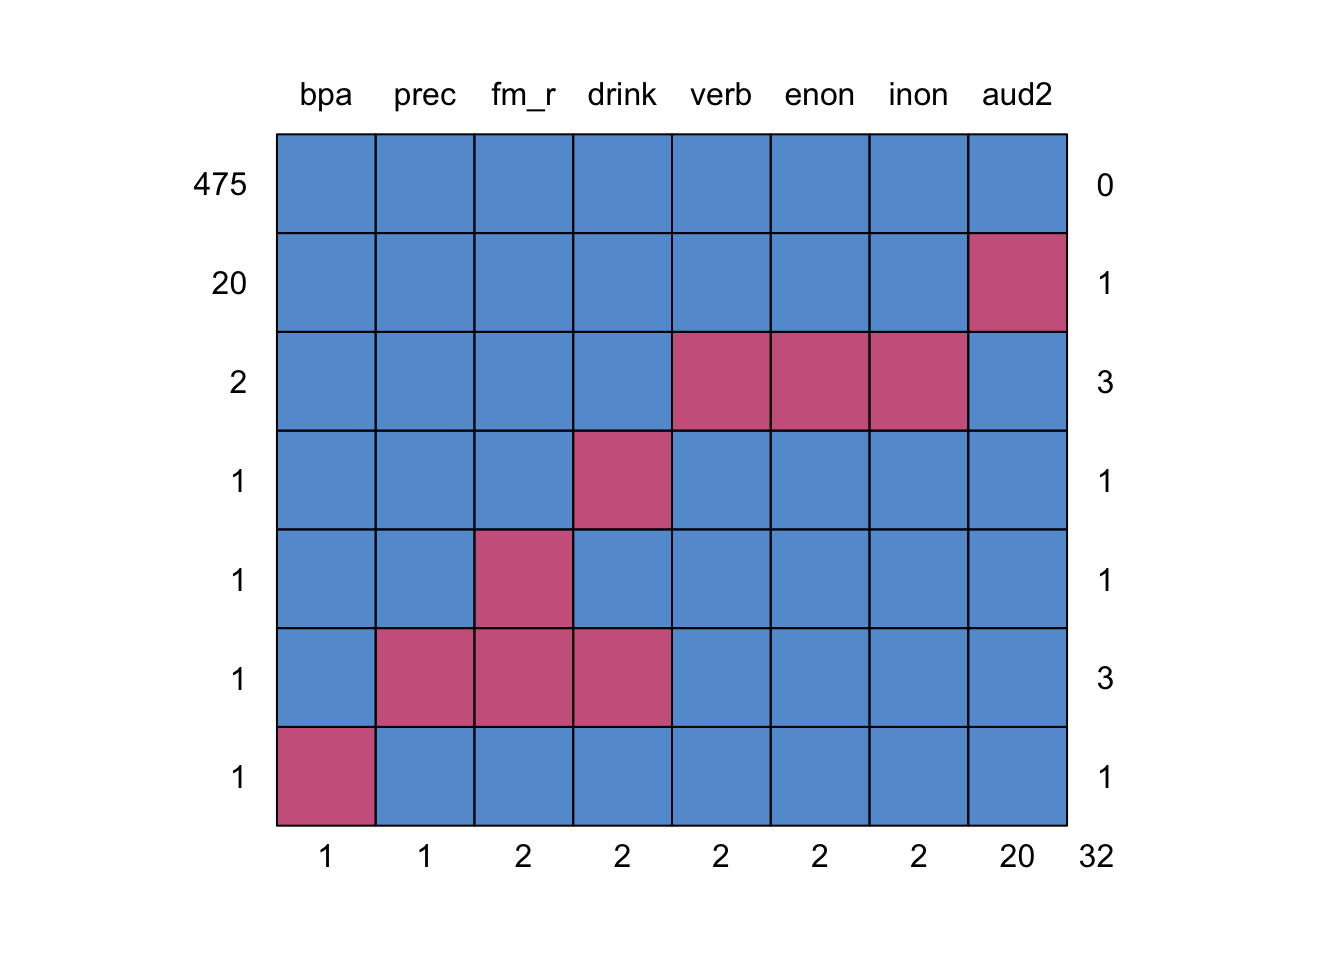

    bpa prec fm_r drink verb enon inon aud2   
475   1    1    1     1    1    1    1    1  0
20    1    1    1     1    1    1    1    0  1
2     1    1    1     1    0    0    0    1  3
1     1    1    1     0    1    1    1    1  1
1     1    1    0     1    1    1    1    1  1
1     1    0    0     0    1    1    1    1  3
1     0    1    1     1    1    1    1    1  1
      1    1    2     2    2    2    2   20 32

In [ ]:
colSums(is.na(df))[colSums(is.na(df)) > 0]


The majority of observations were complete, and no observation exhibited extensive missingness across variables. Given this pattern, multiple imputation with chained equations will be used to address missing data under a missing-at-random assumption.

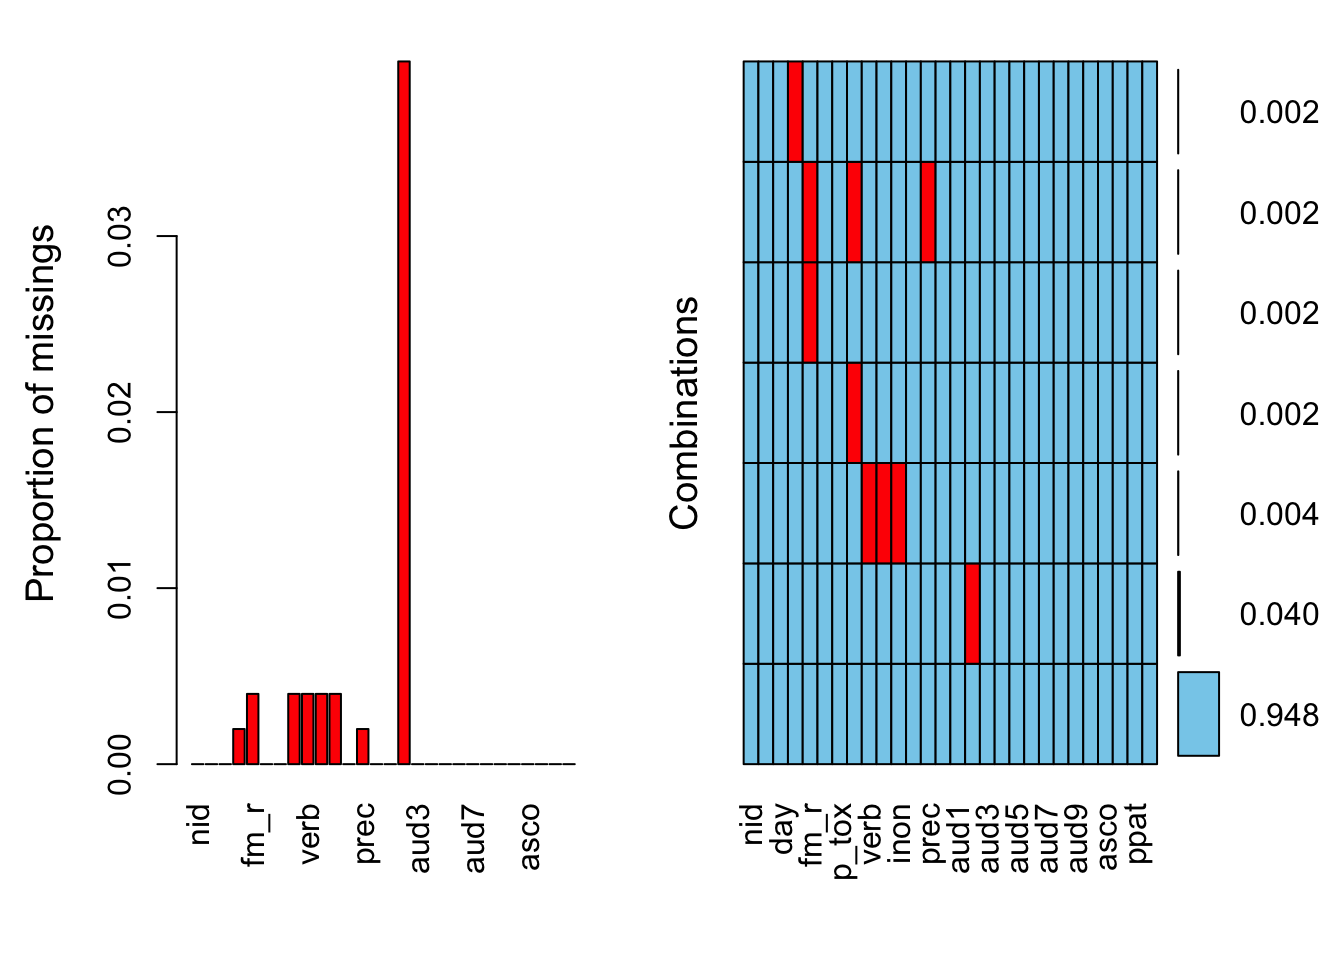

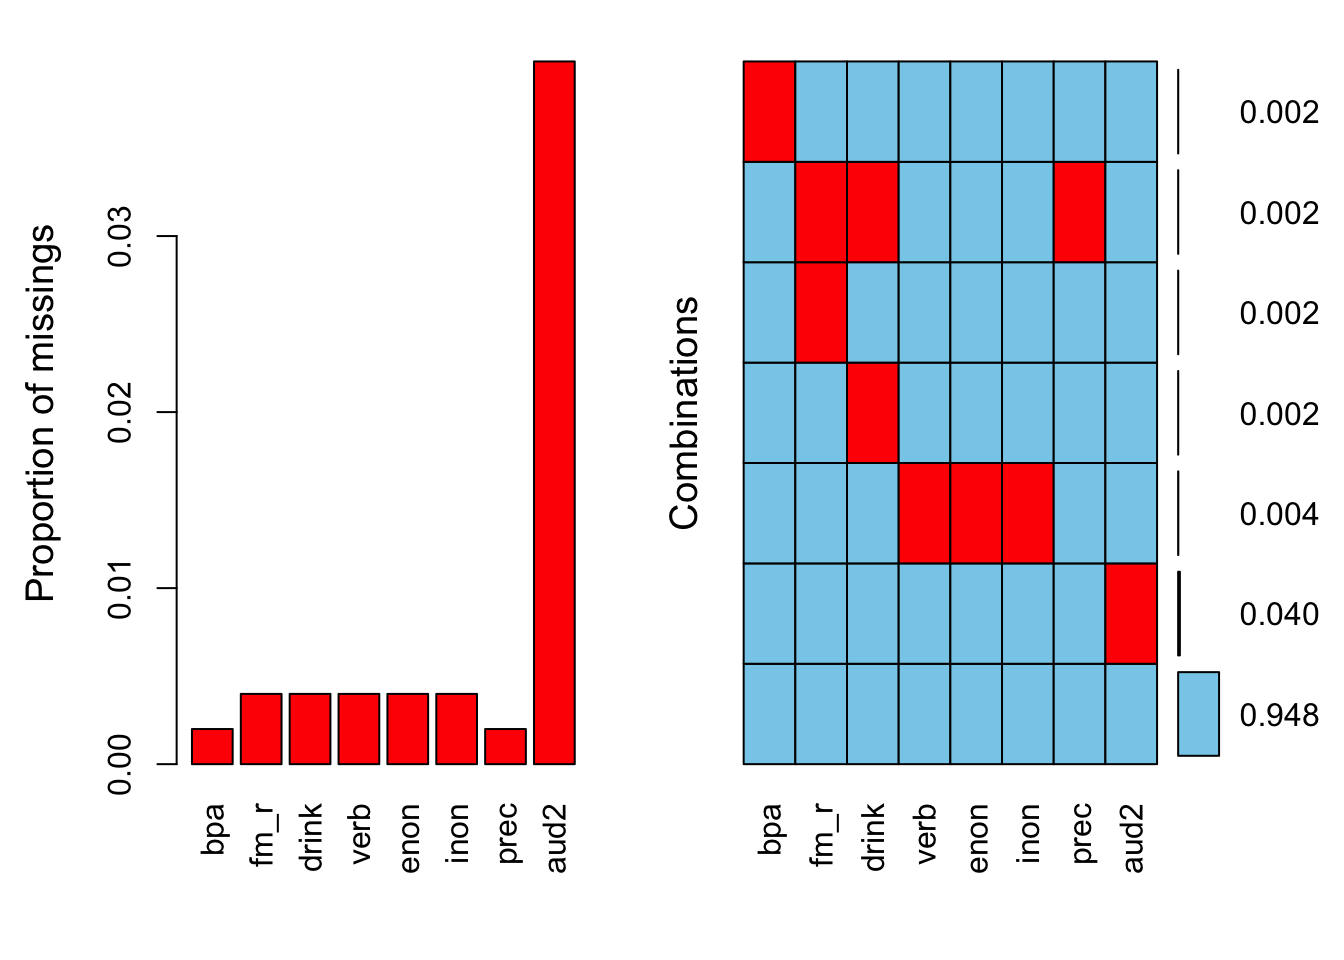

In [ ]:
aggr(df, numbers = TRUE)


### Imputation

Prepare variables

In [ ]:
df <- df %>%
  mutate(
    across(c(prec, gend_di, bpa), ~ factor(.x, levels = c(0, 1))),
    s_act = factor(s_act, levels = c("Contact", "Penetration")))

df_imp <- df %>%
  mutate(                       
    nid = as.integer(nid),  # integer cluster id for mice
    eid = factor(eid), # event identifier as factor
    day = as.integer(day)
  )

rm(b, d, diary, df)

df_imp %>% glimpse()


Rows: 501
Columns: 28
$ nid     <int> 1, 1, 2, 2, 2, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 7, 8, 9, 9, 10…
$ eid     <fct> R_2SGrhBLHNypDxnk, R_2PvxEpTRi3WqoZh, R_1MPW5HzrVXnUzPs, R_3Gj…
$ day     <int> 10, 25, 4, 10, 11, 19, 11, 20, 22, 27, 3, 5, 11, 18, 22, 8, 1,…
$ bpa     <fct> 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,…
$ fm_r    <dbl> 1, 4, 4, 4, 4, 4, 1, 1, 3, 3, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4,…
$ intox   <dbl> 61, 30, 0, 51, 1, 25, 63, 65, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 1…
$ p_tox   <dbl> 25, 26, 0, 34, 1, 25, 66, 68, 0, 27, 0, 0, 0, 0, 0, 0, 1, 0, 2…
$ drink   <dbl> 2, 1, 0, 1, 0, 1, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,…
$ verb    <dbl> 6, 2, 0, 10, 4, 0, 2, 10, 10, 10, 10, 10, 10, 10, 10, 9, 7, 10…
$ enon    <dbl> 4, 8, 10, 4, 9, 10, 10, 10, 10, 10, 1, 5, 5, 5, 5, 10, 7, 10, …
$ inon    <dbl> 1, 3, 10, 6, 9, 10, 10, 10, 10, 10, 1, 5, 5, 4, 5, 6, 10, 10, …
$ s_act   <fct> Contact, Penetration, Contact, Penetration, Penetration, Penet…
$ prec    <fct> 0,

Initialize

In [ ]:
# create default blocks/methods/predictorMatrix
ini <- mice(df_imp, maxit = 0, printFlag = FALSE)

pred   <- ini$predictorMatrix
meth   <- ini$method

# inspect any logged events
ini$loggedEvents


NULL

Declare cluster for 2-level setup and protect structure

In [ ]:
meth["nid"]   <- ""   # do not impute nid (participant ID) itself
pred[, "nid"] <- -2   # declare nid the cluster variable for 2l.* methods
pred["nid", ] <- 0    # nid is not predicted by anything

# event ID not imputed, not a predictor
meth["eid"]      <- ""
pred[, "eid"]    <- 0
pred["eid", ]    <- 0

# day as auxiliary predictor
meth["day"]   <- "" # (not imputed)
pred["day", ] <- 0   # nid is not predicted by anything


Specify methods for variables with missingness

In [ ]:
meth["aud2"]    <- "pmm"
meth["bpa"]     <- "logreg"
meth["prec"]    <- "logreg"
meth["fm_r"]    <- "2l.pmm"
meth["drink"]    <- "2l.pmm"
meth["verb"]    <- "2l.pmm"
meth["enon"]    <- "2l.pmm"
meth["inon"]    <- "2l.pmm"

# don't use nonverbal items to impute verbal
pred["verb", c("enon", "inon")] <- 0

# don't use verbal to impute nonverbal items
pred[c("enon", "inon"), "verb"] <- 0

length(df_imp)                 # number of columns


[1] 28

[1] 28

[1] 28

 [1] "nid"     "eid"     "day"     "bpa"     "fm_r"    "intox"   "p_tox"  
 [8] "drink"   "verb"    "enon"    "inon"    "s_act"   "prec"    "gend_di"
[15] "aud1"    "aud2"    "aud3"    "aud4"    "aud5"    "aud6"    "aud7"   
[22] "aud8"    "aud9"    "aud10"   "asco"    "irma"    "ppat"    "bidr"   

 [1] "nid"     "eid"     "day"     "bpa"     "fm_r"    "intox"   "p_tox"  
 [8] "drink"   "verb"    "enon"    "inon"    "s_act"   "prec"    "gend_di"
[15] "aud1"    "aud2"    "aud3"    "aud4"    "aud5"    "aud6"    "aud7"   
[22] "aud8"    "aud9"    "aud10"   "asco"    "irma"    "ppat"    "bidr"   

In [ ]:
warns <- character(0)

imp <- withCallingHandlers(
  mice(
    df_imp,
    m = 20,
    maxit = 20,
    method = meth,
    predictorMatrix = pred,
    seed = 1234,
    printFlag = TRUE
  ),
  warning = function(w) {
    warns <<- c(warns, conditionMessage(w))
    invokeRestart("muffleWarning")
  }
)



 iter imp variable
  1   1  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   2  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   3  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   4  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   5  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   6  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   7  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   8  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   9  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   10  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   11  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   12  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   13  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   14  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   15  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   16  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   17  bpa  fm_r  drink  verb  enon  inon  prec  aud2
  1   18  bpa  fm_r 

character(0)

In [ ]:
imp


Class: mids
Number of multiple imputations:  20 
Imputation methods:
     nid      eid      day      bpa     fm_r    intox    p_tox    drink 
      ""       ""       "" "logreg" "2l.pmm"       ""       "" "2l.pmm" 
    verb     enon     inon    s_act     prec  gend_di     aud1     aud2 
"2l.pmm" "2l.pmm" "2l.pmm"       "" "logreg"       ""       ""    "pmm" 
    aud3     aud4     aud5     aud6     aud7     aud8     aud9    aud10 
      ""       ""       ""       ""       ""       ""       ""       "" 
    asco     irma     ppat     bidr 
      ""       ""       ""       "" 
PredictorMatrix:
      nid eid day bpa fm_r intox p_tox drink verb enon inon s_act prec gend_di
nid     0   0   0   0    0     0     0     0    0    0    0     0    0       0
eid     0   0   0   0    0     0     0     0    0    0    0     0    0       0
day     0   0   0   0    0     0     0     0    0    0    0     0    0       0
bpa    -2   0   1   0    1     1     1     1    1    1    1     1    1       1
fm_r   

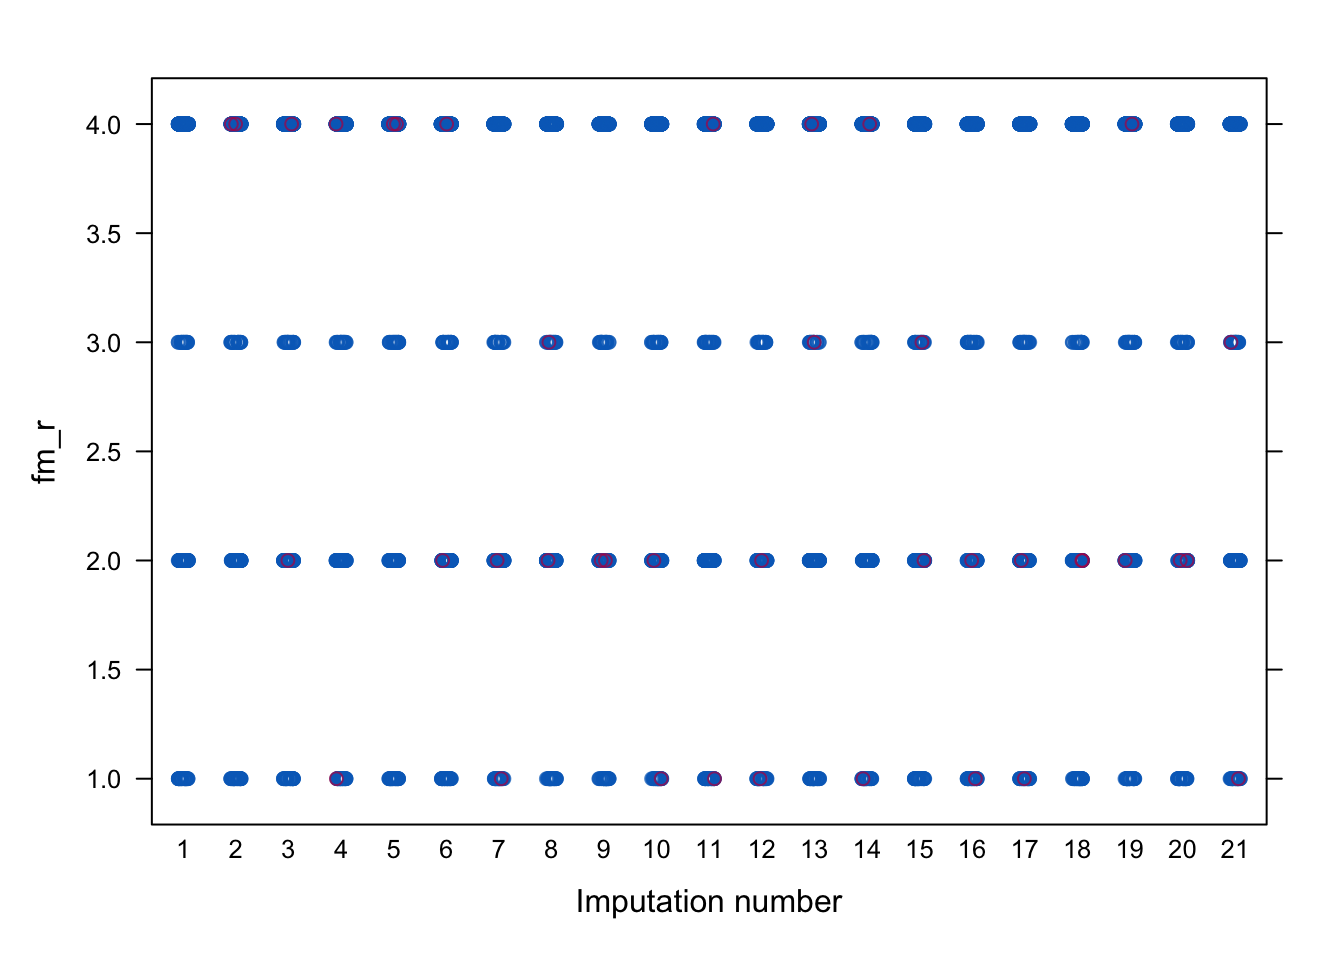

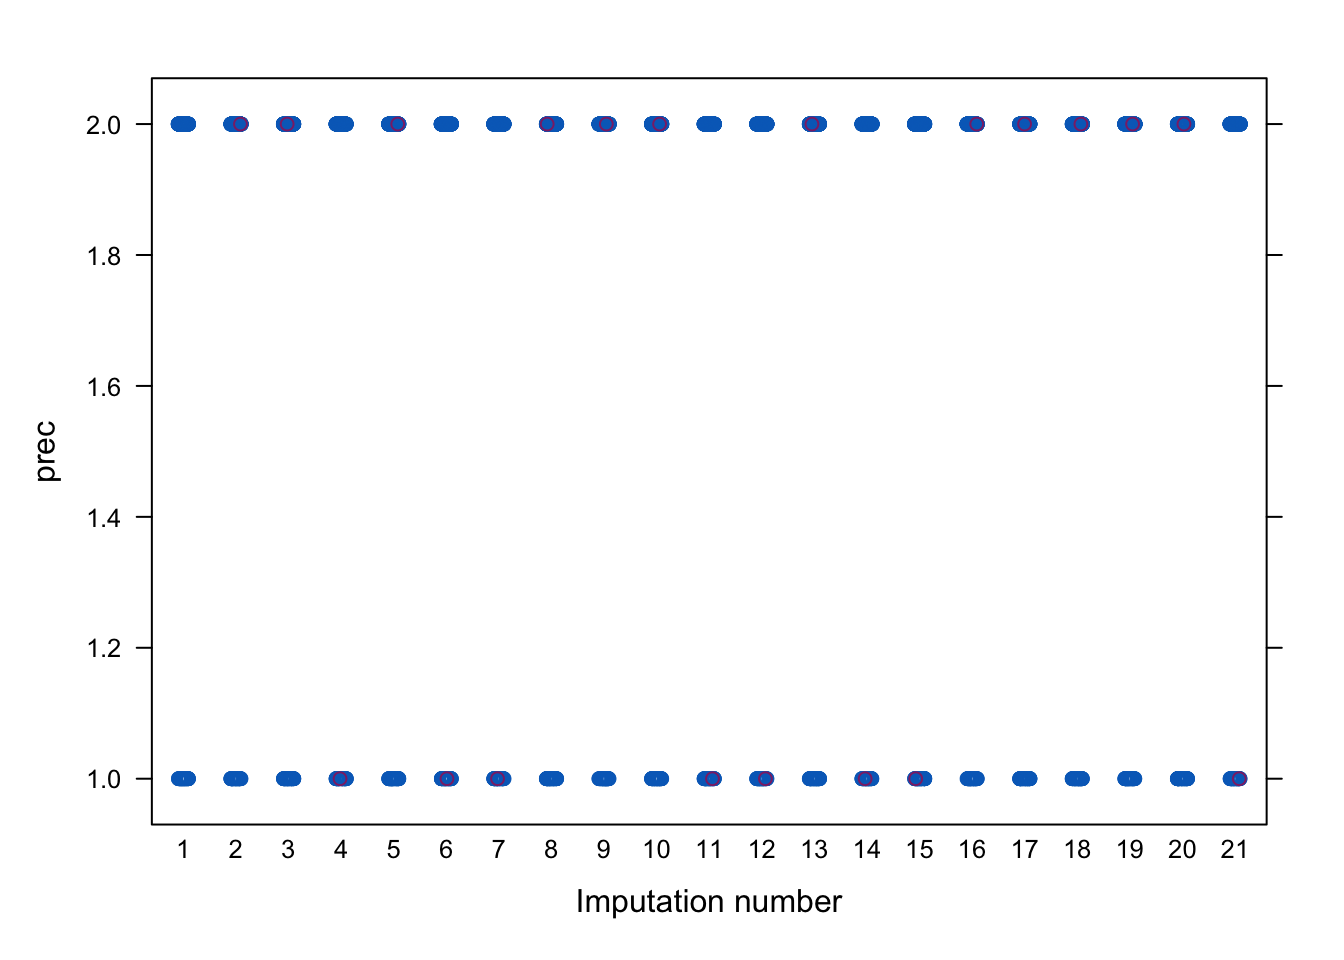

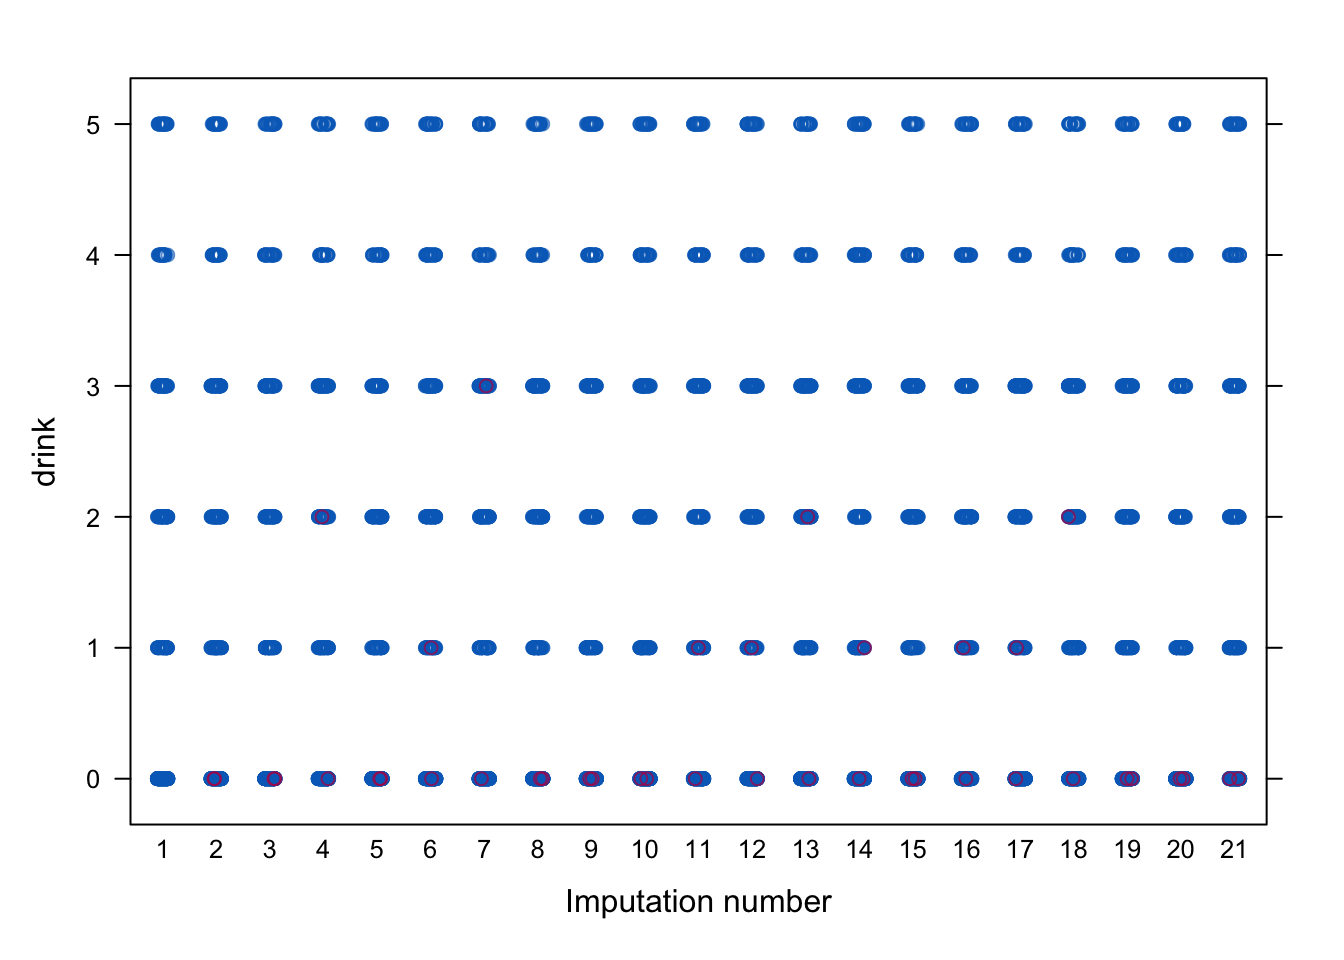

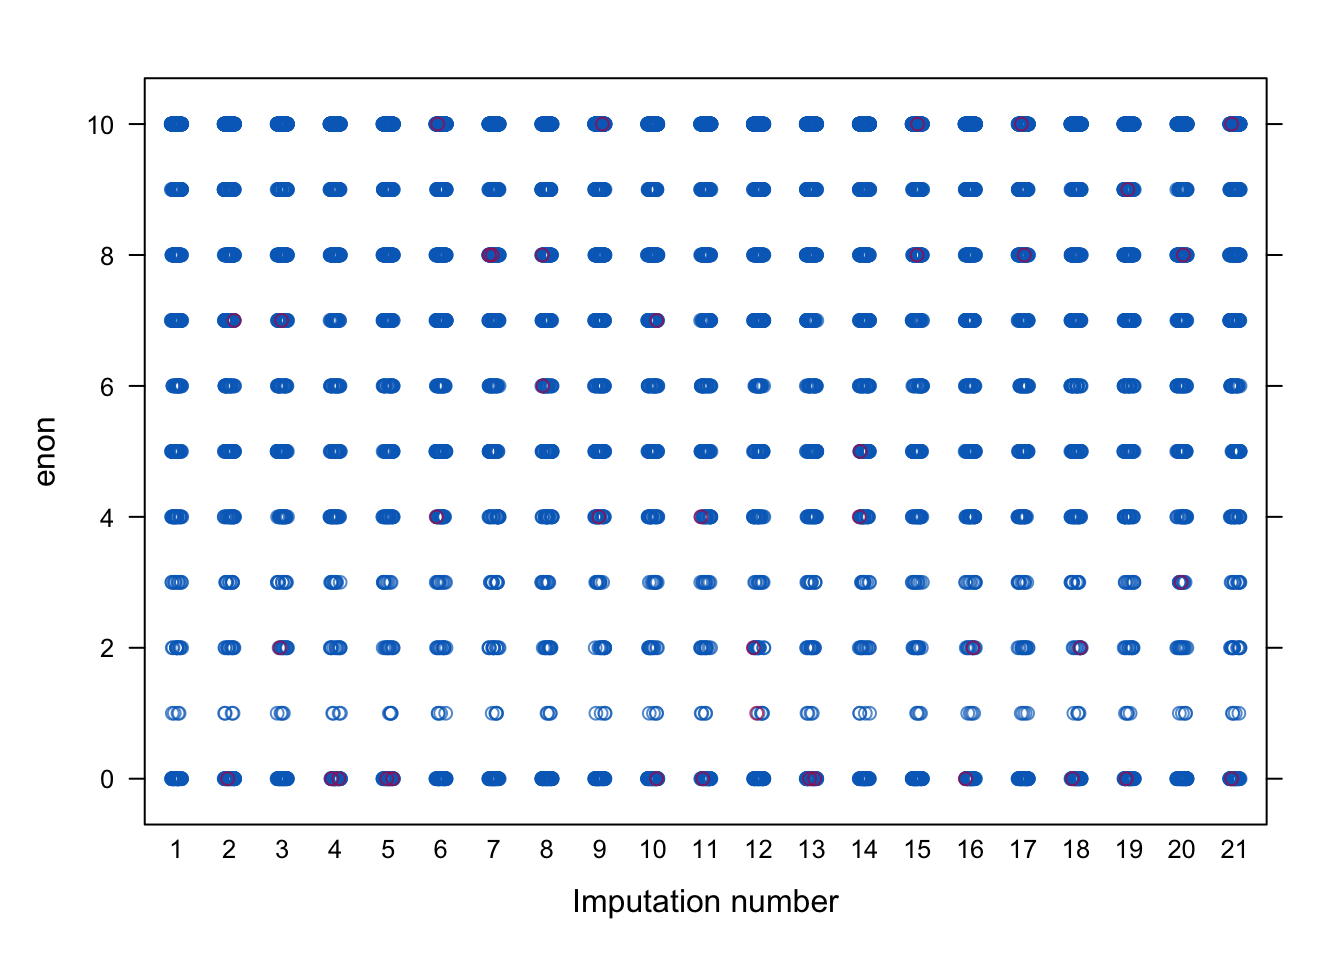

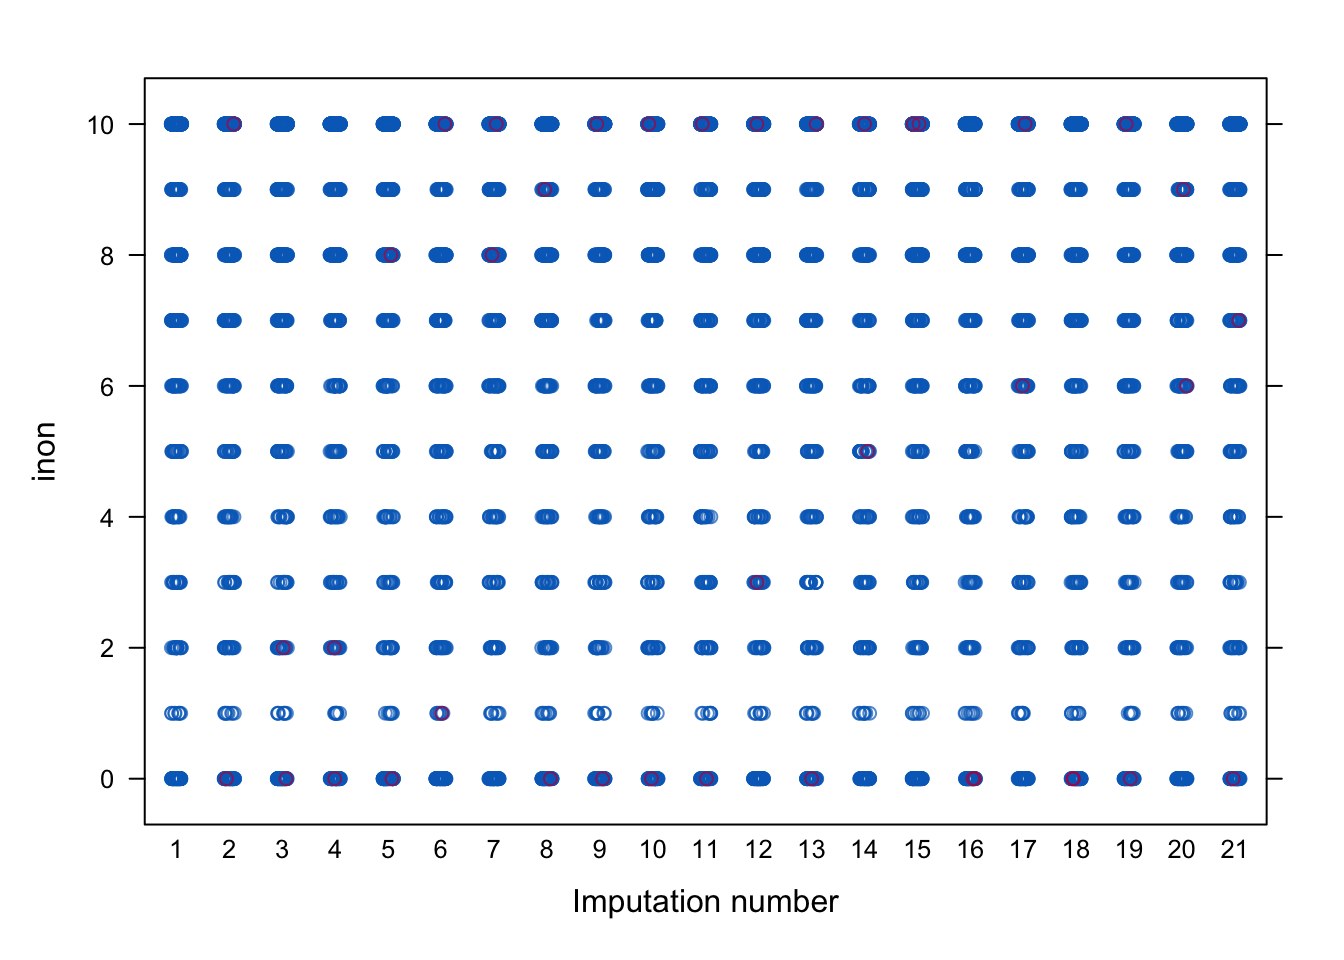

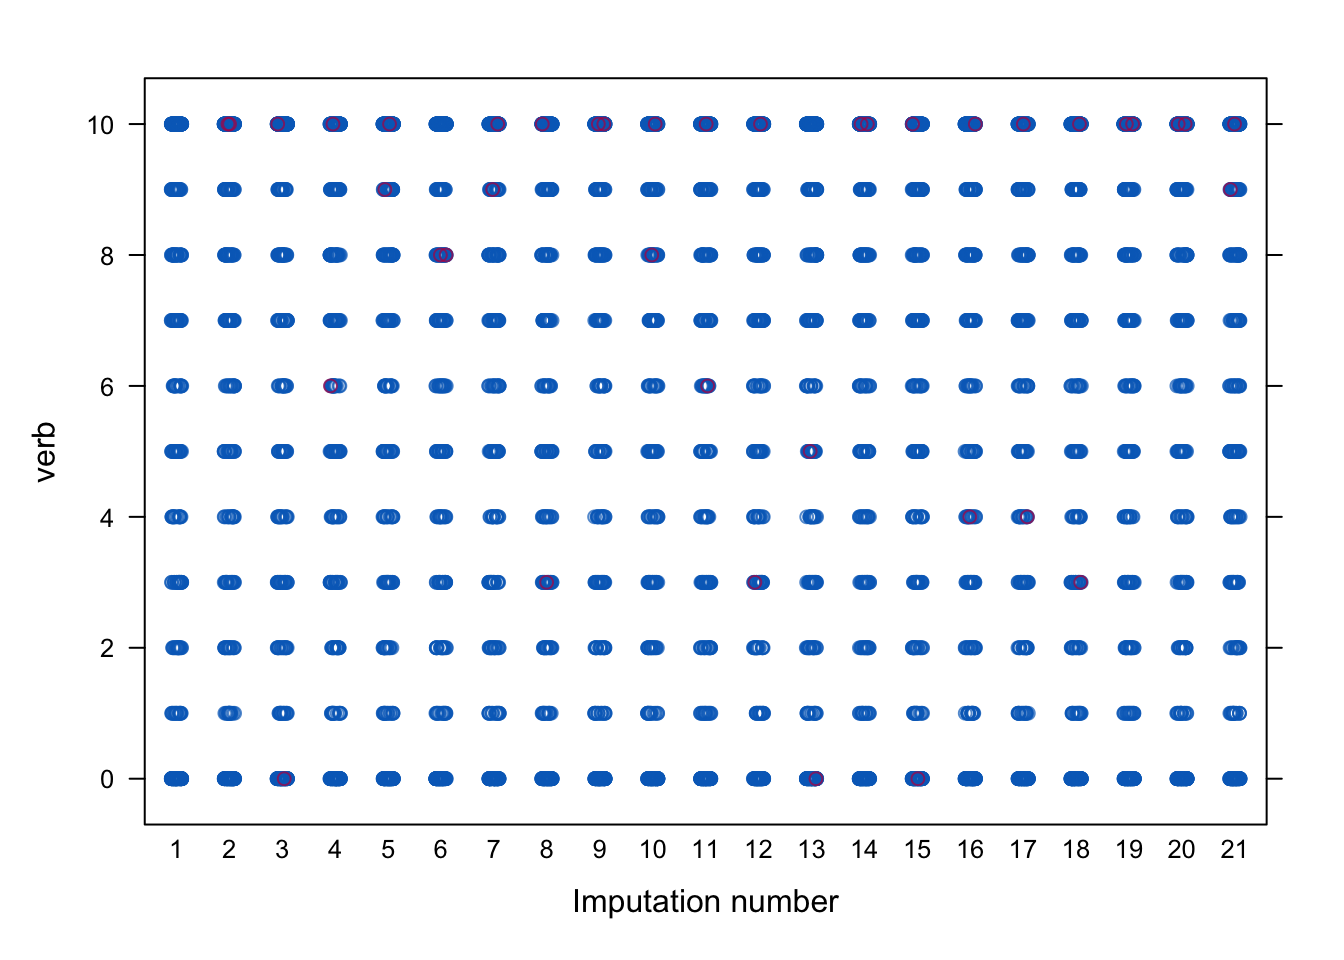

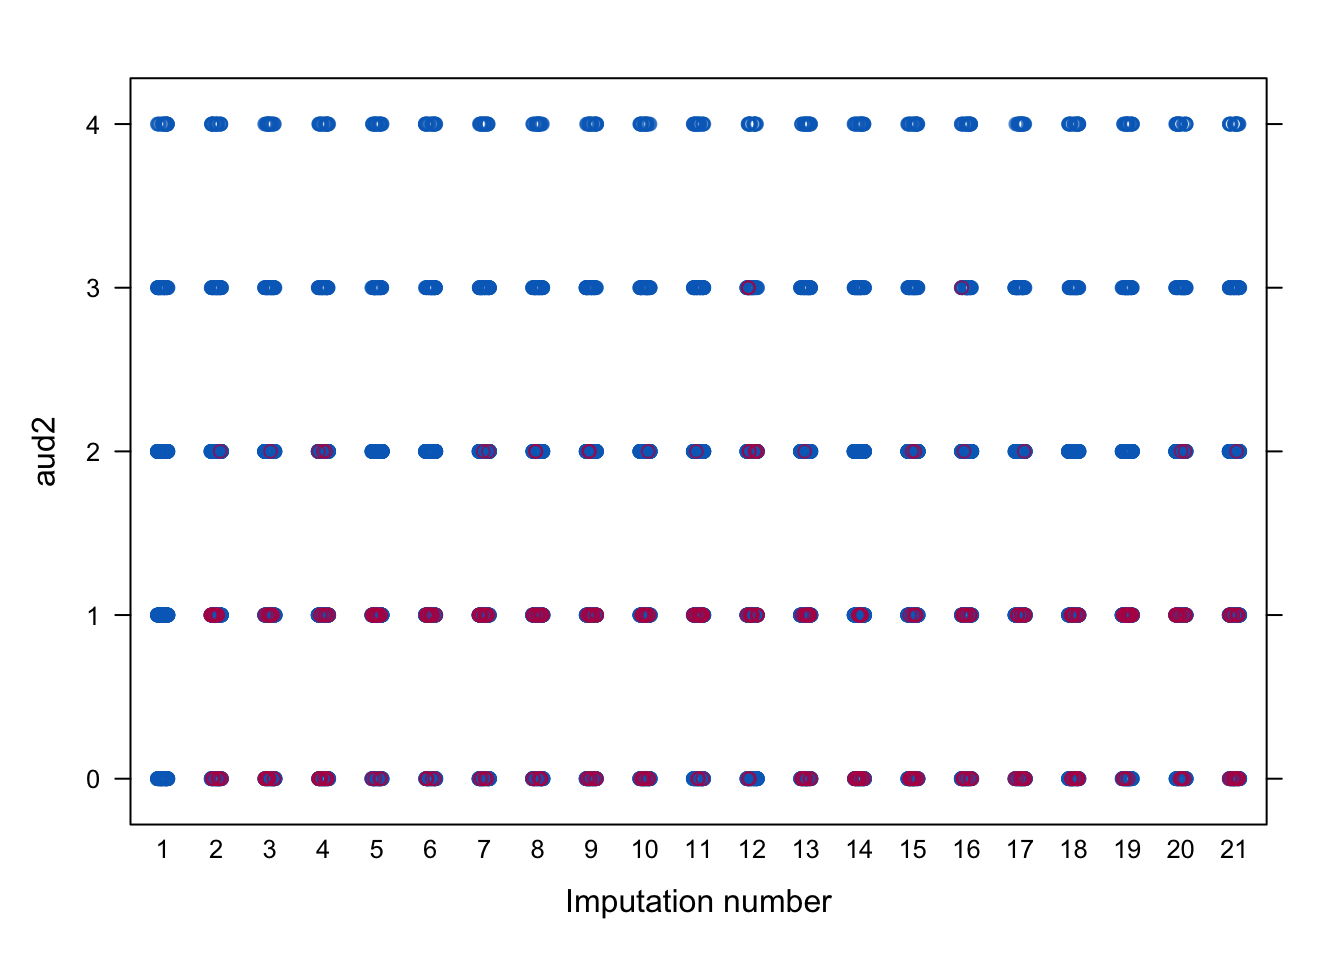

In [ ]:
stripplot(imp, fm_r ~ .imp)


In [ ]:
summary(complete(imp, 1)$fm_r) 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   3.323   4.000   4.000 

  0   1 
 94 407 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    1.02    2.00    5.00 

  0   1 
319 182 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    5.00    8.00    7.06   10.00   10.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   4.000   8.000   6.802  10.000  10.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   7.000   5.673  10.000  10.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.387   2.000   4.000 

In [ ]:
completed_list <- mice::complete(imp, action = "all")


Export as a list of completed dataframes

In [ ]:
saveRDS(
  completed_list,
  here::here(path_ready, "miced_datasets.rds"))


Export individual CSV files (one .csv per imputation)

In [ ]:
purrr::iwalk(
  completed_list,
  ~ write_csv(.x, here::here(path_ready, paste0("miced_", .y, ".csv")))
)
